<div class="fluid-row" id="section-header">
    <h2 class="title toc-ignore">Master Data Science & Big Data - ENSIAS</h2>
    <h4 class="author"><em>pacman</em></h4>
    <h4 class="date"><em>Mai 17, 2018</em></h4>
</div>
<center>
    <h1>
        <u>Deep Learning in Computer Vision</u>
    </h1>
    <h4>Realized by : Ayoub RMIDI</h4>
</center>
<div class="fluid-row" id="section-header">
    <h2 class="title toc-ignore">Introduction</h2>
    <p class="lead">The business problem I will try to solve, is classifying images of published ads from Avito website, personally many times, by mistake when I am trying to upload pictures to sell a phone for example, I found my self putting it into laptops category which is not the case, so the idea is to adopt a Deep Learning model that can classify the uploaded images in the right class in real time based on Avito's data set that we will scrap to train our model.<br>
In this notebook I will cover only 2 classes which are <b>phone</b> and <b>laptops</b> for simplicity, hence we can improve our model later by adding multiple classes. The following notebook would be presented as follow :
    <ol class="lead">
        <li>Data Collection</li>
        <li>Data Preprocessing</li>
        <li>Data Exploration</li>
        <li>Data Modeling</li>
        <li>Model Deployment & Evaluation</li>
    </ol>
<p>
</div>

# 1. Data Collection

<p class="lead">The data we will work on is a set of images scrapped from Avito.ma for each category laptops and moto, the resulted folder will contain two sub directories called respectively "laptop" and "phone" and the size of downloaded images is 120x90, with 3 channels RGB for each one. Here is the following code doing the data scrapping.</p>

In [2]:
# we import needed libraries
import tensorflow as tf
from skimage import data
import matplotlib.pyplot as plt
import os, random, time, shutil, requests
import pandas as pd
import numpy as np
from skimage import transform
from matplotlib import pyplot
from lxml import html

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
tf.logging.set_verbosity(tf.logging.INFO)

In [2]:
def save_image(ad_name, file_name, item_link, download_path):
    response = requests.Session().get(item_link, stream=True)

    if response.status_code == 200:
        with open(os.path.join(download_path, file_name), 'wb') as image_file:
            for chunk in response.iter_content(1024):
                image_file.write(chunk)

In [3]:
def scrape_images(url, path):
    response = requests.Session().get(url).text
    #print(response)
    tree = html.fromstring(response)
    for ad in tree.xpath('//div[contains(@class, "item") and contains(@class, "li-hover")]'):
        if ad.xpath('.//img/@data-original'):
            title = ad.findtext('.//h2/a')
            image_url = ad.xpath('.//img/@data-original')[-1]
            image_name = image_url.split('/')[-1]
            save_image(title, image_name, image_url, path)   

In [5]:
basic_url = "https://www.avito.ma/fr/casablanca/ordinateurs_portables-à_vendre?o="
path = 'raw_data/laptop'
print('Starting data scrapping')
for i in range(0,70):
    page_url = basic_url + str(i)
    scrape_images(page_url, path=path)
    if i%10 == 0:
        print('page ',i,'attended')
print('End scrapping images')

Starting data scrapping
page  60 attended
End scrapping images


In [3]:
number_of_laptop_images = len(os.listdir('raw_data/laptop'))
print('there are exactly',number_of_laptop_images,'images on laptop class.')

there are exactly 2097 images on laptop class.


In [4]:
number_of_phone_images = len(os.listdir('raw_data/phone'))
print('there are exactly',number_of_phone_images,'images on phone class.')

there are exactly 2180 images on phone class.


<p class='lead'>At the end we will have a folder containing images of laptops which looks like this :</p>
<img src="notebook_pics/laptops.png">

# 2. Data Preprocessing

<p class='lead'>For the preprocessing task we will divide into two subtasks as follow :</p>
<ol class='lead'>
    <li>Remove noizy Data</li>
    <li>Image resizing</li>
</ol>

## 2.1. Removing Noisy Data

<p class='lead'>To remove noisy data, we have to check every image in the data set and delete those who will not help us to get a good accuracy, as an example we can find in the phone directory an image like this :</p>
<img src='notebook_pics/8000532171.jpg' width='120' height='90'>
<p class='lead'>which represent a phone's packet and not a real phone as we are lookig for, so I delete it.</p> 

## 2.2. Image resizing

<p class="lead">To fit the LeNet-5 [1] Model Architecture, we will have to resize images from 120x90 to 32x32 for each class, So we create a new folder where we will store our resulted data set by creating 2 subfolders called 0 and 1 which refer to <b>laptop</b>,  and <b>phone</b> respectively. The next section show a Snapshot of the code doing this task :</p> 

In [12]:
from PIL import Image

def resize_and_save(target_path, cible_path, dirs):
    for item in dirs:
        im = Image.open(cible_path+item)
        file, extension = os.path.splitext(cible_path+item)
        imResized = im.resize((64, 64), Image.ANTIALIAS)
        filename = file.split('/')[2]
        imResized.save(target_path + filename + extension, 'JPEG', quality=90)

<p class='lead'>Now we call our built-in function for each target and cible directory.</p>

In [14]:
# target_path list
target_path = ['preprocessed_data/phone/', 'preprocessed_data/laptop/']
original_path = ['raw_data/phone/', 'raw_data/laptop/']
print('Starting resizing images ...')
for t, c in zip(target_path, original_path):
    dirs = os.listdir(c)
    resize_and_save(t, c, dirs)
    #print(t, c)
print('End images resizing.')

Starting resizing images ...
End images resizing.


<table class="table table-bordered">
    <thead>
      <tr>
        <th>Before resizing (120x90)</th>
        <th>After resizing (64x64)</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td><img src="raw_data/laptop/0005474607.jpg"></td>
        <td><img src="preprocessed_data/laptop/0005474607.jpg"></td>
      </tr>
    </tbody>
  </table>

<h3>3. Data Exploration</h3>

<p class='lead'>First of all we start by a simple histogram showing the distribution of images per class, to get an idea about the balancing of our data set.</p>

In [5]:
classes = ['phone', 'laptop']
values = [number_of_phone_images, number_of_laptop_images]
ypos = np.arange(len(classes))

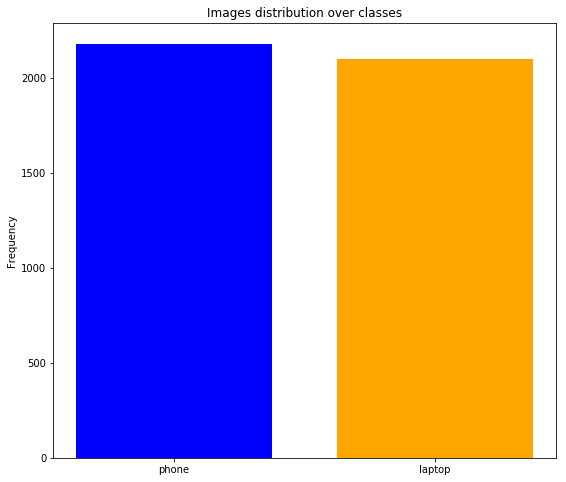

In [6]:
plt.figure(figsize=(9, 8))
plt.xticks(ypos, classes)
plt.ylabel('Frequency')
plt.title('Images distribution over classes')
plt.bar(ypos, values, color=['blue','orange'], width=0.75)
plt.savefig('temp.png')
#plt.show()

<p class='lead'>As we can see from the plot above, the two classes are quite balanced, which is a mandatory step to build a high accurate Deep Learning Model, so that we won't get a class overriding another one.</p>

## 3.1 Data Splitting

<p class='lead'>After exploring the data set, we will start splitting it into training and test set. To perform this task we will split the preprocessed data set into 80% training and 20% for test, for each class.</p>

In [10]:
# we define how many items do we have per class
class_size = [number_of_phone_images, number_of_laptop_images]

In [19]:
def move_training_files(which_class, origin_path, destination, ratio):
    training_size = int(ratio * which_class)
    files = os.listdir(origin_path)
    training_data = files[:training_size]
    for file in training_data:
        shutil.move(origin_path + file, destination + file)

In [24]:
# we define lists of destination and target pathtu m
destination_train_path = ['data/train/phone/', 'data/train/laptop/']
destination_test_path = ['data/validation/phone/', 'data/validation/laptop/']

### Copying Training data

In [25]:
print('Start copying files to train folder ...')
for c, o, d in zip(class_size, target_path, destination_train_path):
    move_training_files(c, o, d, 0.8)
print('End copying files.')

Start copying files to train folder ...
End copying files.


### Copying Validation data

In [26]:
print('Start copying files to train folder ...')
for c, o, d in zip(class_size, target_path, destination_test_path):
    move_training_files(c, o, d, 0.2)
print('End copying files.')

Start copying files to train folder ...
End copying files.


# 4. Data Modeling - Convolutional Neural Network

In [7]:
from keras.layers import Flatten
# Initialise CNN
model = Sequential()

# Add convolution layer
model.add(Conv2D(32, (3, 3), input_shape = (64, 64, 3), activation = 'relu'))

# Add max pooling layer
model.add(MaxPooling2D(pool_size = (2, 2)))

# Add a second convolution layer
model.add(Conv2D(32, (3, 3), activation = 'relu'))

# Add max pooling layer
model.add(MaxPooling2D(pool_size = (2, 2)))

# Flattening the output
model.add(Flatten())

# Add full connection
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dense(units = 2, activation = 'sigmoid'))
 
# Compiling the CNN
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

## Model Summary

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               802944    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total para

## Loading images and Data Transformation

<p class='lead'>To feed images to our compiled model, we will have to `ImageDataGenerator` function, this will help us generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).</p>

In [9]:
from keras.preprocessing.image import ImageDataGenerator

# Create an instance for training_data
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# Create an instance for testing_data
validation_datagen = ImageDataGenerator(rescale=1./255)

<p class='lead'>Now that we have created, two instances of `ImageDataGenerator`, we need to feed them with the right path to both training and validation dataset, with a `categorical` class mode.</p>

In [10]:
train_set = train_datagen.flow_from_directory(
        'data/train',
        target_size=(64, 64),
        batch_size=64,
        class_mode='categorical')

validation_set = validation_datagen.flow_from_directory(
        'data/validation',
        target_size=(64, 64),
        batch_size=64,
        class_mode='categorical')

Found 3421 images belonging to 2 classes.
Found 855 images belonging to 2 classes.


<p class='lead'>The last but not the least step is to make our built-in model fit the dataset, for this reason we feed it with the `train_set` and `validation_set` already created, and start the training session.<br>But before that we will set a callback to visualize the training evolution using TensorBoard.</p>

In [12]:
from keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir='./tf-log', histogram_freq=0,
                         write_graph=True, write_images=False )

In [22]:
model.fit_generator(
        train_set,
        steps_per_epoch=100,
        epochs=25,
        validation_data=validation_set,
        validation_steps=2000, callbacks = [TrainValTensorBoard(write_graph=True)])

Epoch 1/25
100/100 [==============================] - 107s 1s/step - loss: 0.3987 - acc: 0.8140 - val_loss: 0.4216 - val_acc: 0.7982
Epoch 2/25
100/100 [==============================] - 108s 1s/step - loss: 0.3680 - acc: 0.8279 - val_loss: 0.4074 - val_acc: 0.8036
Epoch 3/25
100/100 [==============================] - 100s 1s/step - loss: 0.3404 - acc: 0.8417 - val_loss: 0.4365 - val_acc: 0.7923
Epoch 4/25
100/100 [==============================] - 102s 1s/step - loss: 0.3451 - acc: 0.8429 - val_loss: 0.3840 - val_acc: 0.8187
Epoch 5/25
100/100 [==============================] - 101s 1s/step - loss: 0.3320 - acc: 0.8524 - val_loss: 0.4020 - val_acc: 0.8182
Epoch 6/25
100/100 [==============================] - 102s 1s/step - loss: 0.3158 - acc: 0.8646 - val_loss: 0.3401 - val_acc: 0.8409
Epoch 7/25
100/100 [==============================] - 100s 1s/step - loss: 0.2881 - acc: 0.8705 - val_loss: 0.3499 - val_acc: 0.8579
Epoch 8/25
100/100 [==============================] - 105s 1s/step - 

<p class=lead>Usually we build a test set apart from the validation where we evaluate our final trained model, but we will keep it simple and validate it only on the same validation set.

In [23]:
validation_sample_size = 800
model.evaluate_generator(validation_set, validation_sample_size)

[0.3527091883856247, 0.8772840283984867]

<p class='lead'>As result we got a validation accuracy of 83.27% with a loss value of 0.37 which is kind of critical a bit, since it's still need to decrease.</p>

## Saving Models

In [19]:
# save models weights on hdf5 extension
models_dir = 'models/'
model.save(models_dir+'avito_model.h5')

In [20]:
# serialize model to JSON
model_json = model.to_json()
with open(models_dir+'avito_model.json', 'w') as json_file:
    json_file.write(model_json)

## Test Model on some samples

In [21]:
from keras.preprocessing.image import img_to_array
from PIL import Image
def preprocess_image(image,target_size):
    if image.mode != "RGB":
        image = image.convert("RGB")
    image = image.resize(target_size)
    image = img_to_array(image)
    image = np.expand_dims(image,axis = 0)
    return image

In [22]:
img = Image.open("5531569558.jpg")

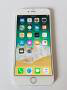

In [23]:
img

In [24]:
processed_image = preprocess_image(img,target_size = (64, 64))

In [25]:
matrix = []
matrix.append(processed_image)
prediction = model.predict(matrix).tolist()

In [26]:
prediction

[[0.0, 1.0]]

In [27]:
if np.asscalar(np.argmax(prediction, axis=1)) == 0:
    print('Laptop')
else:
    print('Phone')

Phone
